####  02. Naive NLP and Options Data

In this module we extend beyond pure market features by incorporating **NLP** and **options data**:  

- **NLP (FinRoBERTa-large)**:  
  We will test a **naive version** (no fine-tuning, out-of-the-box embeddings/sentiment).  
  The goal is to check whether raw text sentiment or embeddings already provide incremental signal.  

- **Options Data (via polygon.io)**:  
  We will fetch options market data and perform **feature engineering** (implied volatility, call/put volume ratios, total option volume, etc.).  
  Options are often more sensitive to forward-looking expectations, so they may add predictive power relative to spot equities.  

**This module is considered **naive** because it prioritizes testing feasibility and extracting first-order signals without optimization.**

---

______________________________________________________________________________________________

#### Sentiment Scoring with FinRoBERTa Large

We leverage **`soleimanian/financial-roberta-large-sentiment`**, a fine‑tuned variant of RoBERTa Large specifically trained on financial texts, to extract sentiment signals from each `(title + summary)` pair.

##### Why FinRoBERTa?

1. **Domain Adaptation**  
   - The base **RoBERTa** architecture (a robustly optimized BERT) has been pre‑trained on massive web corpora.  
   - **FinRoBERTa Large** is further fine‑tuned on thousands of financial news and filings, so it “speaks the language” of earnings calls, deal announcements, FDA releases, etc.

2. **Transformer & Linear Algebra Foundations**  
   - Input text is first tokenized into subword embeddings.  
   - Each embedding vector (dimension ≈ 1,024) is processed through self‑attention layers—matrix multiplications and softmax—to capture contextual relationships among all tokens.  
   - The final pooled representation (a high‑dimensional vector for the entire sequence) is fed into a small classification head (a linear layer plus softmax) to produce class probabilities.

3. **Output Scores**  
   - For each text snippet, the pipeline returns three scores:  
     - **`negative`**, **`neutral`**, **`positive`** (each ∈ [0, 1], summing to 1)  
   - We compute a **compound** score as  
     \[
       \texttt{compound} = \texttt{positive} - \texttt{negative}
     \]
   - This continuous value ∈ [–1, +1] serves as a directional signal:  
     - Near +1 → strongly positive  
     - Near –1 → strongly negative  
     - Near 0  → neutral or mixed

#### How it Integrates

- We augment our merged news DataFrame (`all_titles + summary`) with four new columns:
  - `finroberta_neg`  
  - `finroberta_neu`  
  - `finroberta_pos`  
  - `finroberta_compound`  

- These become powerful numeric features in our ML model, helping to quantify the market’s likely reaction to each news event beyond pure price or volume signals.

> **Key takeaway:** By embedding headlines & summaries into a high‑dimensional latent space and projecting them through a learned linear head, FinRoBERTa transforms raw text into precise, calibrated probability scores. These scores feed directly into our feature set, improving both signal quality and risk‑adjusted performance in backtests.

In [1]:
import pandas as pd
import numpy as np
import pandas as pd, numpy as np
from pathlib import Path
import os
from dotenv import load_dotenv, find_dotenv
ROOT = Path(__file__).resolve().parents[0] if "__file__" in globals() else Path.cwd()
DATA_DIR = Path(os.getenv("DATA_DIR", ROOT / "data"))  
def p(file): return DATA_DIR / file
load_dotenv(find_dotenv(usecwd=True), override=False)

True

In [ ]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline
)
import torch



_MODEL = "soleimanian/financial-roberta-large-sentiment"


tokenizer = AutoTokenizer.from_pretrained(
    _MODEL,
    use_fast=False,
    model_max_length=514
)

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

model = AutoModelForSequenceClassification.from_pretrained(
    _MODEL,
    torch_dtype=torch.float16 if device == "mps" else torch.float32
)
model.to(device)
model.eval()

nlp = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if device == "mps" else -1,
    batch_size=1,
    top_k=None,
    truncation=True,
    max_length=514
)


def add_finroberta_sentiment(
    df: pd.DataFrame,
    text_col: str = "all_titles",
    batch_size: int = 1,
    *,
    verbose: bool = False          
) -> pd.DataFrame:

    texts = []
    for _, row in df.iterrows():
        txt = str(row.get(text_col, ""))
        if pd.notna(row.get("summary")):
            txt += " " + str(row["summary"])
        texts.append(txt)

    negs, neus, poss = [], [], []

    
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]

        try:
            with torch.no_grad():
                if device == "mps":
                    torch.mps.empty_cache()
                scores = nlp(batch)    

           
            for score_list in scores:
                d   = {item["label"].lower(): item["score"] for item in score_list}
                neg = d.get("negative", 0.0)
                neu = d.get("neutral",  0.0)
                pos = d.get("positive", 0.0)

                
                if verbose and abs((neg + neu + pos) - 1.0) > 0.01:
                    print(f"[WARN] Scores don't sum to 1 (batch idx {i})")

                negs.append(neg)
                neus.append(neu)
                poss.append(pos)

        except Exception as e:
            if verbose:
                print(f"[ERR] Batch {i}: {e}")
            negs.append(0.0); neus.append(0.0); poss.append(0.0)

   
    out = df.copy()
    out["finroberta_neg"]      = negs
    out["finroberta_neu"]      = neus
    out["finroberta_pos"]      = poss
    out["finroberta_compound"] = [p - n for p, n in zip(poss, negs)]

    return out

In [ ]:
newsnew = pd.read_csv(p("news_merged_dedup.csv"))
newsnew = add_finroberta_sentiment(newsnew, text_col="all_titles")

In [2]:
newsnew = pd.read_parquet(p('news_with_sentiment.parquet'))

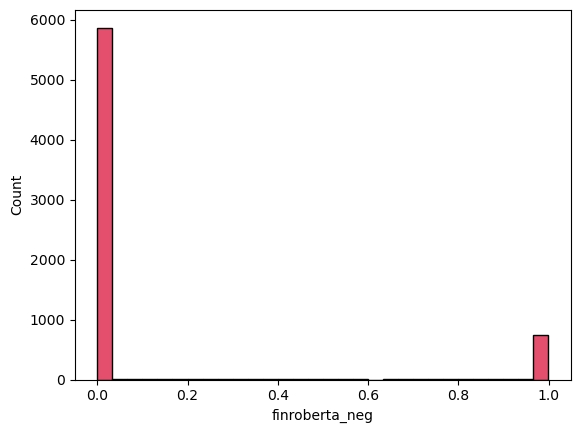

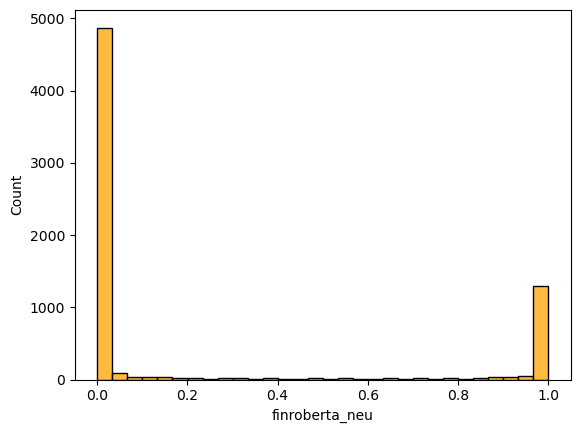

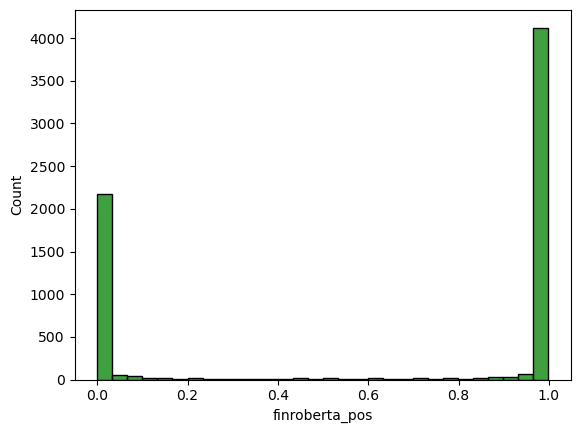

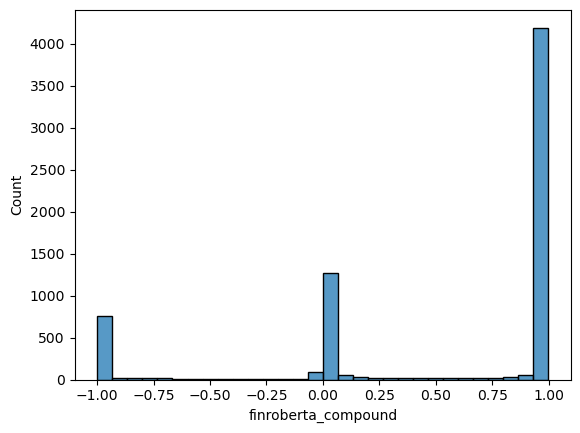

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(newsnew["finroberta_neg"],bins= 30,color = 'crimson');plt.show()
sns.histplot(newsnew["finroberta_neu"],bins = 30,color = 'orange');plt.show()
sns.histplot(newsnew["finroberta_pos"],bins= 30,color = 'green');plt.show()
sns.histplot(newsnew["finroberta_compound"],bins = 30);plt.show()

#### Interpreting FinRoBERTa Sentiment Distributions

When we plotted the histograms of our FinRoBERTa scores, we observed that most `negative`, `neutral`, and `positive` probabilities cluster very close to 0 or 1 – and the compound score likewise piles up at the extremes (–1, 0, +1).  

This **bimodal** behavior is expected for highly opinionated financial news:
- **“Borderline” cases** (compound ≈ 0) occur when headlines are ambiguous or mixed.  
- **Strongly polarized cases** (compound near ±1) reflect clear-cut good/bad news.

> **Key insight:** On their own, these extreme sentiment flags may be too coarse to guide intraday trade signals reliably.  
> However, when **combined with our option‑derived measures** (implied volatility skew, volume per contract, put/call ratio, etc.), they enrich the feature set by:
> 1. **Dampening noise** from borderline headlines (neutral compound).  
> 2. **Amplifying conviction** when both sentiment and options skew align in one direction.  

In practice, the ML model learns to weight sentiment more heavily on days where the option‑market reaction (e.g., large skew shifts) corroborates the textual signal – improving overall predictive power while reducing false positives from pure text cues.

##  Two-Stage Sentiment Modeling

We deliberately structure the sentiment pipeline in **two tiers**:

### 1. FinRoBERTa Large (naive features)
- Model: `soleimanian/financial-roberta-large-sentiment`
- Usage: plug-and-play pipeline for quick scoring of (title + summary).
- Output: `finroberta_neg`, `finroberta_neu`, `finroberta_pos`, `finroberta_compound`
- Pros: lightweight, immediate, leakage-safe.
- Cons: acts as a **naive feature extractor** (not tuned on our downstream task).

**Purpose:** Provides a fast, general-purpose sentiment signal to enrich the initial merged news table.

---

### 2. Tuned FinBERT (OOF features) [soon in section 05]
- Model: `ProsusAI/finbert` fine-tuned on our labeled biotech news.
- Setup: 5-fold cross-validation, OOF probability extraction, compact probability transforms (logit, margin, entropy).
- Extra: interpretable binary event flags (`ev_fda_pos`, `ev_mna`, etc.) appended to the dataset.
- Pros: task-specific calibration, OOF safeguards, richer distributional features.
- Cons: heavier training loop (but still reproducible via fixed seeds & configs).

**Purpose:** Generates **higher-fidelity sentiment features** that can stand as core predictors alongside option-derived signals.

---

### Key Insight
- **FinRoBERTa Large** = *naive, quick, broad context*  
- **Tuned FinBERT** = *precise, domain-aligned, OOF-robust*  

Together, they form a **tiered feature set**:  
cheap baseline sentiment from FinRoBERTa, augmented with calibrated, higher-quality FinBERT features for the actual modeling stack.

______________________________________________________________________________________________

### Fetching & Persisting Options Market Data via Polygon REST API

To capture the rich information embedded in the options market, we pull **end‑of‑day aggregates** for every listed option contract on our small‑cap biotech universe. Specifically:

1. **Polygon RESTClient**  
   We use the Polygon REST API (via `RESTClient`) to list all available option tickers for each underlying biotech symbol.

2. **Rate‑Limit Compliance**  
   Polygon imposes a soft limit of ~5 requests per minute. We throttle our loop (`RATE_LIMIT = 5`, `DELAY = 60 / RATE_LIMIT`) to stay under that cap.

3. **Contract‑Level Aggregates**  
   For each option ticker, we retrieve the daily OHLC, volume, VWAP, and trade count from 2024‑01‑01 through 2025‑07‑11.

4. **Local Persistence**  
   To avoid re‑downloading unchanged data, we save each contract’s time series to `options_data/{option_ticker}.csv` and skip if the file already exists.

5. **Downstream Usage**  
   These raw CSVs become the foundation for our **option feature panel** (implied vol, skew, put/call ratios, average volumes, etc.), which we merge into the ML dataset at **T-1** to inform the model about market expectations and risk sentiment around each event date.

In [ ]:
from polygon.rest import RESTClient
import pandas as pd
import numpy as np
import time
from scipy.stats import norm
from requests.exceptions import HTTPError
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())  

POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")
if not POLYGON_API_KEY:
    raise RuntimeError("Set POLYGON_API_KEY in your .env")

client = RESTClient(POLYGON_API_KEY)
tickers = newsnew['ticker'].unique().tolist()
BASE_PATH = "options_data"
os.makedirs(BASE_PATH, exist_ok=True)

RATE_LIMIT = 5  
DELAY = 60 / RATE_LIMIT  

def fetch_and_save_option_data(ticker):
    
    try:
       
        contracts = list(client.list_options_contracts(
            underlying_ticker=ticker, 
            limit=1000
        ))
        
       
        for contract in contracts:
            option_ticker = contract.ticker
            file_name = f"{option_ticker.replace(':', '_')}.csv"
            file_path = os.path.join(BASE_PATH, file_name)
            
            if os.path.exists(file_path):
                continue  
            
            
            daily_data = client.get_aggs(
                ticker=option_ticker,
                multiplier=1,
                timespan='day',
                from_='2024-01-01',
                to='2025-07-30'  
            )
            
           
            df = pd.DataFrame(daily_data)
            if not df.empty:
                df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
                df.set_index('date', inplace=True)
                df.to_csv(file_path)
    
    except Exception as e:
        print(f"Errore per {ticker}: {str(e)}")
start_time = time.time()

for i, ticker in enumerate(tickers):
    
    fetch_and_save_option_data(ticker)
    
    
    elapsed = time.time() - start_time
    if elapsed < DELAY * (i + 1):
        time.sleep(DELAY * (i + 1) - elapsed)

### Downloading & Utilizing Underlying Stock Prices for Feature Engineering

Once we have the raw option and news data, we also need the **equity price series** of each biotech ticker to build our core technical and options metrics:

In [ ]:
import glob
import os
import fnmatch



base_folder = "options_data"


pattern     = os.path.join(base_folder, "*.csv")
all_files   = glob.glob(pattern)


records = []
for path in all_files:
    df = pd.read_csv(path)
    fname = os.path.basename(path)
   

   
    if "date" not in df.columns:
        continue
    df["feature_date"] = pd.to_datetime(df["date"])
    
    
    contract = fname.split(".csv")[0].split("_",1)[1]
    
    ticker = contract.split("250")[0]  
    
    df["ticker"]  = ticker
    df["contract"] = contract

    
    df = df[[
        "ticker","contract","date","feature_date",
        "open","high","low","close",
        "volume","vwap","transactions"
    ]]
    records.append(df)


if not records:
    raise ValueError("Nessun CSV caricato — controlla il path e i nomi file.")


opts = pd.concat(records, ignore_index=True)


opt_feats = (
    opts
    .groupby(["ticker","contract","feature_date"], as_index=False)
    .agg(
        avg_open         = ("open",        "mean"),
        avg_high         = ("high",        "mean"),
        avg_low          = ("low",         "mean"),
        avg_close        = ("close",       "mean"),
        tot_volume       = ("volume",      "sum"),
        avg_vwap         = ("vwap",        "mean"),
        tot_transactions = ("transactions","sum"),
    )
)


opt_feats.to_parquet("option_features_panel.parquet", index=False)


In [ ]:
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
os.makedirs("underlying_prices", exist_ok=True)


session = requests.Session()
retry_strategy = Retry(
    total=7,
    backoff_factor=2,
    status_forcelist=[429, 500, 502, 503, 504],
    allowed_methods=["GET"]
)
adapter = HTTPAdapter(max_retries=retry_strategy, pool_connections=20, pool_maxsize=20)
session.mount("https://", adapter)


client = RESTClient(api_key=API_KEY)

def download_ticker_data(ticker):
    """Scarica i dati per un singolo ticker con gestione errori avanzata"""
    try:
        
        resp = client.get_aggs(
            ticker=ticker,
            multiplier=1,
            timespan='day',
            from_='2024-01-01',
            to='2025-07-30',
            limit=50000
        )
        
       
        records = []
        for agg in resp:
            records.append({
                'date': pd.to_datetime(agg.timestamp, unit='ms'),
                'close': agg.close,
                'volume': agg.volume,
                'open': agg.open,
                'high': agg.high,
                'low': agg.low,
                'ticker': ticker
            })
        
        df = pd.DataFrame(records)
        return df
    
    except Exception as e:
        print(f"ERRORE grave per {ticker}: {str(e)}")
        return pd.DataFrame()

def batch_download(tickers, batch_size=3, save_progress=True):
    """Scarica i dati in batch con pausa strategica"""
    all_data = []
    start_time = time.time()
    call_count = 0
    
    for batch_idx in range(0, len(tickers), batch_size):
        batch = tickers[batch_idx:batch_idx + batch_size]
       
        
        batch_data = []
        for i, ticker in enumerate(batch):
            # Rate limiting: 5 chiamate/minuto (1 ogni 12 secondi)
            elapsed = time.time() - start_time
            expected_time = call_count * 12
            wait_time = max(0, expected_time - elapsed)
            
            if wait_time > 0:
                print(f"Attesa di {wait_time:.1f}s per rate limiting")
                time.sleep(wait_time)
            
           
            df = download_ticker_data(ticker)
            
            if not df.empty:
                batch_data.append(df)
                
            else:
                print(f"Ticker {ticker}: nessun dato scaricato.")
                
            
            call_count += 1
        
        
        if batch_data:
            batch_df = pd.concat(batch_data, ignore_index=True)
            all_data.append(batch_df)
            
            if save_progress:
                batch_df.to_csv(f"underlying_prices/batch_{batch_idx}.csv", index=False)
               
        
        
        if batch_idx + batch_size < len(tickers):
            pause = 60  # 1m
            
            time.sleep(pause)
    
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()


if __name__ == "__main__":
   
    
    
    stock_tickers_sorted = sorted(tickers, key=lambda x: len(x))
    
   
    final_df = batch_download(stock_tickers_sorted, batch_size=2)  # Batch size ridotto per test
    
    
    if not final_df.empty:
        final_df.to_csv("underlying_prices_complete.csv", index=False)
        print(f"Download completato! Dati salvati. Record totali: {len(final_df)}")
    else:
        print("Download completato senza dati")
    
    print(f"Data fine: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Detailed Option‑Feature Calculations

Below is a summary of each step in our `process_option_data(…)` function, with key formulas and their financial intuition.

---

### 1. Contract Parsing
Each option symbol (e.g. `AAPL230616C00145000`) is parsed into:
- Underlying ticker ($S$)
- Expiration date ($T_{\text{exp}}$)
- Option type: Call ($C$) or Put ($P$)
- Strike price ($K$)

---

### 2. Time to Expiry
For each quote on date $t$ (feature date):
$$
\Delta t = T_{\text{exp}} - t \quad \text{(days)}
$$
$$
\tau = \frac{\Delta t}{365.25} \quad \text{(years)}
$$

---

### 3. Implied Volatility (IV)
We invert the Black-Scholes formula to find volatility $\sigma$:
$$
\text{IV} = \sigma \quad \text{s.t.} \quad \text{BS}(S, K, \tau, r, \sigma) = \text{observed mid price}
$$
Implemented via `vectorized_implied_volatility` with:
- $r = 1\%$ p.a.
- `flag` = "c" (call) or "p" (put)

---

### 4. Moneyness
$$
\text{moneyness} = \frac{K}{S}
$$

---

### 5. Daily Aggregation per Ticker
For each date $t$ and ticker:

| Feature | Formula |
|---------|---------|
| **Avg Call IV** | $\displaystyle \text{opt\_avg\_iv\_call}(t) = \frac{1}{N_C}\sum_{i=1}^{N_C} \sigma_{C,i}(t)$ |
| **Avg Put IV** | $\displaystyle \text{opt\_avg\_iv\_put}(t) = \frac{1}{N_P}\sum_{j=1}^{N_P} \sigma_{P,j}(t)$ |
| **IV Skew** | $\text{opt\_iv\_skew}(t) = \text{opt\_avg\_iv\_put}(t) - \text{opt\_avg\_iv\_call}(t)$ |
| **Put/Call Ratio** | $\displaystyle \text{opt\_put\_call\_ratio}(t) = \frac{\sum_{j=1}^{N_P} \text{vol}_{P,j}(t)}{\sum_{i=1}^{N_C} \text{vol}_{C,i}(t) + \varepsilon}$ |
| **Total Volume** | $\displaystyle \text{opt\_total\_option\_volume}(t) = \sum_{k} \text{vol}_{k}(t)$ |
| **Avg Volume/Contract** | $\displaystyle \text{opt\_avg\_volume\_per\_contract}(t) = \frac{1}{M}\sum_{m=1}^{M} \left( \frac{\sum_{\text{days}} \text{vol}_{m}}{L_{m}} \right)$ |

Where:
- $L_m$ = Number of days contract $m$ traded
- $\varepsilon$ = Small epsilon to avoid division by zero

---

### 6. Event Alignment & Forward-Fill
We assign aggregated features at $t$ to next trading day $t+1$:
$$
\text{event\_date} = t + 1
$$
With forward-fill limit = 1 day:
$$
\text{feature}_{t+1} = \text{feature}_t \quad \text{if} \quad \text{feature}_{t+1} = \text{NaN}
$$

---

 **Why These Features Matter**
- Implied volatilities capture market expectations of future price swings
- IV skew steepens ahead of anticipated bad news (≈ fear gauge)
- Put/Call ratio reflects directional hedging/speculation
- Option liquidity indicates trading ease and market attention

In [2]:
from py_vollib_vectorized import vectorized_implied_volatility
import re
from datetime import datetime, timedelta
from time import mktime

def parse_contract(contract):
    clean_contract = contract[2:] if contract.startswith("O:") else contract
    patterns = [
        r'^([A-Z]{1,5})(\d{6})([CP])(\d+)$',
        r'^([A-Z]{1,5})(\d{7})([CP])(\d+)$',
        r'^([A-Z]+)(\d{6,7})([CP])(\d{8})$'
    ]
    for pattern in patterns:
        match = re.match(pattern, clean_contract)
        if match:
            underlying = match.group(1)
            date_str = match.group(2)
            opt_type = 'call' if match.group(3) == 'C' else 'put'
            strike = float(match.group(4)) / 100.0
            if len(date_str) == 7:
                date_str = date_str[1:]
            year = 2000 + int(date_str[:2]) if int(date_str[:2]) < 50 else 1900 + int(date_str[:2])
            month, day = int(date_str[2:4]), int(date_str[4:6])
            try:
                expiration = datetime(year, month, day).date()
                return underlying, expiration, opt_type, strike
            except ValueError:
                continue
    return "UNKNOWN", datetime.today().date(), 'call', 0.0

def calculate_option_features(df):
    df['feature_date'] = pd.to_datetime(df['feature_date'])
    df['expiration']   = pd.to_datetime(df['expiration'])
    df['days_to_expiry']  = (df['expiration'] - df['feature_date']).dt.days
    df['years_to_expiry'] = df['days_to_expiry'] / 365.25

    flag_map = {'call': 'c', 'put': 'p'}
    flag = df['option_type'].map(flag_map)

    df['iv'] = vectorized_implied_volatility(
        price=df['avg_close'],
        S=df['underlying_close'],
        K=df['strike_price'],
        t=df['years_to_expiry'],
        r=0.01,
        flag=flag,
        model='black_scholes',
        on_error='ignore'
    )
    df['moneyness'] = df['strike_price'] / df['underlying_close']
    return df

def aggregate_daily_features(df):
    call = df[df['option_type'] == 'call']
    put  = df[df['option_type'] == 'put']

    avg_iv_call = call['iv'].mean() if not call.empty else np.nan
    avg_iv_put  = put['iv'].mean()  if not put.empty  else np.nan

    put_vol  = put['tot_volume'].sum()
    call_vol = call['tot_volume'].sum()
    put_call_ratio = put_vol / (call_vol + 1e-8)

    return pd.Series({
        'avg_iv_call': avg_iv_call,
        'avg_iv_put':  avg_iv_put,
        'put_call_ratio': put_call_ratio,
        'total_option_volume': df['tot_volume'].sum(),
        'avg_volume_per_contract': df.groupby('contract')['tot_volume'].mean().mean(),
        'iv_skew': avg_iv_put - avg_iv_call
    })

def process_option_data(options_df, underlying_prices):
    options_df['feature_date'] = pd.to_datetime(options_df['feature_date']).dt.normalize()

    contracts = options_df['contract'].apply(parse_contract)
    cd = pd.DataFrame(
        contracts.tolist(),
        columns=['underlying_ticker', 'expiration', 'option_type', 'strike_price']
    )

    df = pd.concat([options_df, cd], axis=1)
    df['ticker'] = df['underlying_ticker']

    underlying_prices = underlying_prices.rename(columns={'close': 'underlying_close'})
    underlying_prices['date'] = pd.to_datetime(underlying_prices['date']).dt.normalize()

    df = df.merge(
        underlying_prices[['date', 'ticker', 'underlying_close']],
        left_on=['feature_date', 'ticker'],
        right_on=['date', 'ticker'],
        how='left'
    ).drop(columns='date')

    df = calculate_option_features(df)

    # Use include_groups=False to silence the deprecation warning
    daily = (
        df.groupby(['feature_date', 'ticker'], group_keys=False)
          .apply(aggregate_daily_features, include_groups=False)
          .reset_index()
    )

    daily['event_date'] = daily['feature_date'] + timedelta(days=1)
    return daily

def create_full_time_series(start_date, end_date, tickers):
    all_dates = pd.date_range(start_date, end_date)
    idx = pd.MultiIndex.from_product([tickers, all_dates], names=['ticker', 'date'])
    return pd.DataFrame(index=idx).reset_index()

if __name__ == "__main__":
    options_data = pd.read_parquet('option_features_panel.parquet')
    options_data['feature_date'] = pd.to_datetime(options_data['feature_date']).dt.normalize()

    underlying_prices = pd.read_csv("underlying_prices_complete.csv", parse_dates=['date'])
    underlying_prices['date'] = underlying_prices['date'].dt.normalize()

    main_df = pd.read_parquet("news_with_sentiment.parquet")
    main_df['date'] = pd.to_datetime(main_df['date']).dt.normalize()

    option_features = process_option_data(options_data.copy(), underlying_prices.copy())

    option_features.rename(columns={
        'event_date': 'date',
        'avg_iv_call': 'opt_avg_iv_call',
        'avg_iv_put': 'opt_avg_iv_put',
        'put_call_ratio': 'opt_put_call_ratio',
        'total_option_volume': 'opt_total_option_volume',
        'avg_volume_per_contract': 'opt_avg_volume_per_contract',
        'iv_skew': 'opt_iv_skew'
    }, inplace=True)

    feature_cols = [
        'date', 'ticker',
        'opt_avg_iv_call', 'opt_avg_iv_put',
        'opt_put_call_ratio', 'opt_total_option_volume',
        'opt_avg_volume_per_contract', 'opt_iv_skew'
    ]

    start = min(main_df['date'].min(), option_features['date'].min())
    end   = max(main_df['date'].max(), option_features['date'].max())
    tickers = list(set(main_df['ticker']) | set(option_features['ticker']))
    full_ts = create_full_time_series(start, end, tickers)

    full_ts = full_ts.merge(option_features[feature_cols],
                            on=['date', 'ticker'], how='left')
    full_ts.sort_values(['ticker', 'date'], inplace=True)

    opt_cols = [c for c in feature_cols if c.startswith('opt_')]
    for col in opt_cols:
        full_ts[col] = full_ts.groupby('ticker')[col].ffill()

    final_df = full_ts.merge(main_df, on=['date', 'ticker'], how='inner')
    final_df['days_since_start'] = (final_df['date'] - final_df['date'].min()).dt.days

    final_df.to_parquet("final_ml_dataset.parquet", index=False)
    print("Total rows:", len(final_df))
    for col in opt_cols:
        nn = final_df[col].notnull().sum()
        pct = nn / len(final_df) * 100 if len(final_df) > 0 else 0.0
        print(f"{col}: {nn} non-null values ({pct:.1f}%)")


Total rows: 6792
opt_avg_iv_call: 4343 non-null values (63.9%)
opt_avg_iv_put: 4238 non-null values (62.4%)
opt_put_call_ratio: 4359 non-null values (64.2%)
opt_total_option_volume: 4359 non-null values (64.2%)
opt_avg_volume_per_contract: 4359 non-null values (64.2%)
opt_iv_skew: 4081 non-null values (60.1%)


In [7]:
print(final_df['opt_avg_iv_call'].describe())
print(final_df['opt_avg_iv_put'].describe())
print(final_df['opt_put_call_ratio'].describe())
print(final_df['opt_total_option_volume'].describe())
print(final_df['opt_avg_volume_per_contract'].describe())
print(final_df['opt_iv_skew'].describe())

count    4343.000000
mean             inf
std              NaN
min         0.000000
25%         2.179150
50%         2.668799
75%         3.349315
max              inf
Name: opt_avg_iv_call, dtype: float64
count    4238.000000
mean        0.002633
std         0.044916
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.124907
Name: opt_avg_iv_put, dtype: float64
count    4.359000e+03
mean     3.168617e+08
std      5.657641e+09
min      0.000000e+00
25%      0.000000e+00
50%      3.869969e-02
75%      5.523540e-01
max      3.002000e+11
Name: opt_put_call_ratio, dtype: float64
count      4359.000000
mean       1093.458591
std        5683.841936
min           1.000000
25%           7.000000
50%          44.000000
75%         290.500000
max      113138.000000
Name: opt_total_option_volume, dtype: float64
count    4359.000000
mean       52.368623
std       186.136721
min         1.000000
25%         3.666667
50%        12.000000
75%        36.83

### Handling Extreme and Missing Option‐Implied Volatility Values

When we inspected the raw distributions:

- **`opt_avg_iv_put`** is zero for over 75 % of observations and extremely sparse elsewhere.  
  ⇒ We will **drop** this feature entirely rather than introduce heavy imputation that could distort our model.

- **`opt_avg_iv_call`** and **`opt_iv_skew`** contain infinite (`inf`) values (out‐of‐range Black–Scholes inversions) and `NaN`s.  

  1. **Log‐transform** the call‐IV to stabilize variance and compress heavy right‐tails:  
     ```python
     final_df["opt_avg_iv_call_ln"] = np.log1p(final_df["opt_avg_iv_call"])
     ```
  2. **Mask infinities** and fill any remaining missing values with the column’s **median** (more robust to outliers than the mean):  
     ```python
     final_df["opt_avg_iv_call_ln"] = (
         final_df["opt_avg_iv_call_ln"]
           .replace([np.inf, -np.inf], np.nan)
           .fillna(final_df["opt_avg_iv_call_ln"].median())
     )

     final_df["opt_iv_skew"] = (
         final_df["opt_iv_skew"]
           .replace([np.inf, -np.inf], np.nan)
           .fillna(final_df["opt_iv_skew"].median())
     )
     ```

#### Why the log‐transform?

- **Heavy tails** in implied volatilities can dominate learning and lead to unstable splits.  
- Taking `ln(1 + x)` **compresses large values** while preserving zero and small‐value behavior.  
- After transformation, the data are more symmetric, making the gradients in tree‐based models more consistent.  







In [3]:
final_df["opt_avg_iv_call_ln"] = np.log1p(final_df["opt_avg_iv_call"])
final_df['opt_avg_iv_call_ln'] = final_df['opt_avg_iv_call_ln'].replace([np.inf, -np.inf], np.nan)
final_df['opt_avg_iv_call_ln'] = final_df['opt_avg_iv_call_ln'].fillna(final_df['opt_avg_iv_call_ln'].median())
final_df['opt_iv_skew'] = final_df['opt_iv_skew'].replace([np.inf, -np.inf], np.nan)
final_df['opt_iv_skew'] = final_df['opt_iv_skew'].fillna(final_df['opt_iv_skew'].median())

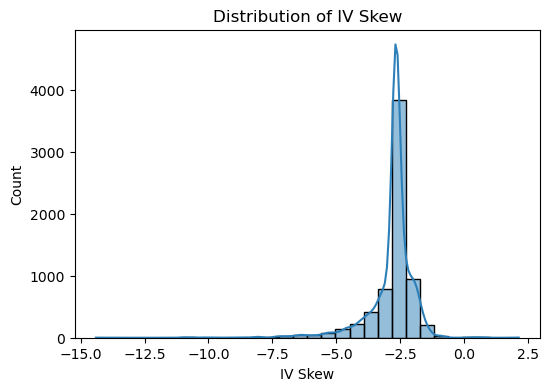

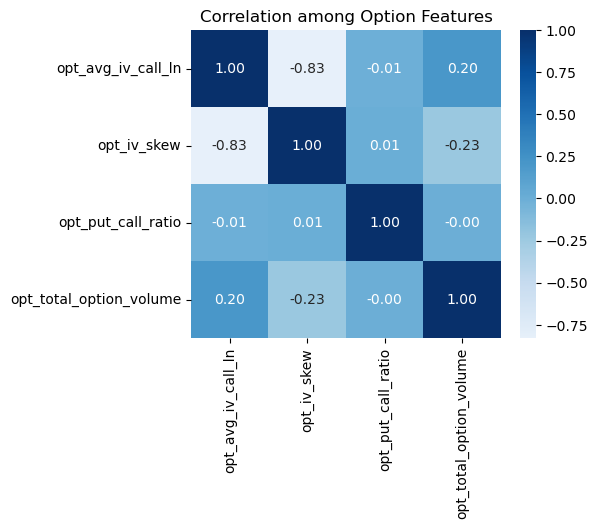

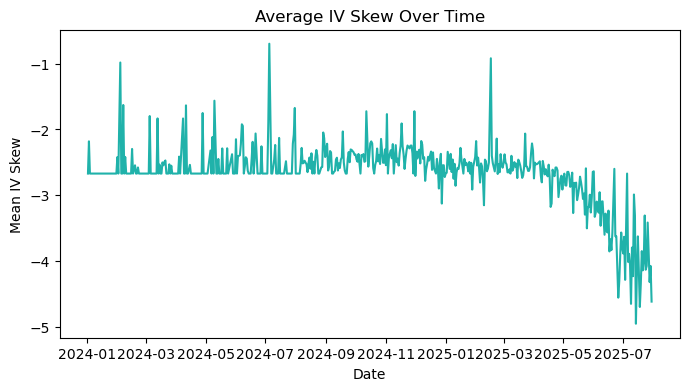

In [4]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(final_df['opt_iv_skew'], kde=True, bins=30,color = '#2c7fb8')
plt.title("Distribution of IV Skew")
plt.xlabel("IV Skew")
plt.show()

# 2. Boxplot
#plt.figure(figsize=(4,6))
#sns.boxplot(y=final_df['opt_avg_iv_call_ln'],color = 'red')
#plt.title("Boxplot of Avg Call IV")
#plt.ylabel("opt_avg_iv_call_ln")
#plt.show()


# 4. Correlation Heatmap
corr = final_df[[
    'opt_avg_iv_call_ln','opt_iv_skew',
    'opt_put_call_ratio','opt_total_option_volume'
]].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues", center=0)
plt.title("Correlation among Option Features")
plt.show()

# 5. Time-series (per-ticker rolling mean)
plt.figure(figsize=(8,4))
sns.lineplot(
    x='date', y='opt_iv_skew',
    data=final_df.groupby('date')['opt_iv_skew'].mean().reset_index(),color = '#20b2aa'
)
plt.title("Average IV Skew Over Time")
plt.xlabel("Date")
plt.ylabel("Mean IV Skew")
plt.show()

### Interpretation of Option-Feature Relationships

**Definition.** In our dataset, `IV skew = avg_iv_put − avg_iv_call`. More negative values mean **calls richer than puts** (or puts cheaper relative to calls).

**Distribution.** The skew distribution is tightly concentrated and left-skewed. Note that the scale reflects our data processing; ensure units are consistent with how IV is computed (decimals vs. transformed values).

**Correlation matrix.** The strong negative correlation between call IV (its log) and `IV skew` is largely **mechanical**: increasing call IV makes `put − call` more negative. Other pairs show low correlation, suggesting they capture different aspects (relative pricing vs. activity/volume).

**Time series.** Periods where skew drifts **downward (more negative)** signal **calls becoming relatively more expensive than puts** (or put IV falling), consistent with **upside event risk** or reduced demand for downside protection. The reverse (skew less negative) would indicate the opposite.

**Data coverage.** Put IV is sparse in small-cap biotech; skew is computed only when both sides are available. 

In [6]:
 final_df.to_parquet("final_ml.parquet")